In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# Lista de arquivos silver da Bovespa
file_list = [
     "COTAHIST_A2019",
     "COTAHIST_A2020",
     "COTAHIST_A2021",
     "COTAHIST_A2022",
     "COTAHIST_A2023",
     "COTAHIST_A2024",
     "COTAHIST_A2025",
]

# Carregar os tickers do IBOV da camada silver
df_ibov = pd.read_parquet("silver/ibov/ibov.parquet")

df_ibov


,ticker
0,ALOS3
1,ABEV3
2,ASAI3
3,AURE3
4,AMOB3
...,...
82,VAMO3
83,VBBR3
84,VIVA3
85,WEGE3


In [3]:
tickers_ibov = df_ibov['ticker'].unique()
tickers_ibov.size

87

# Carrega os arquivos da silver para a gold concatena em único dataframe depois cálcula e salva a volatilidade total e por ano individual

In [4]:
# Carregar tickers do IBOV
df_ibov = pd.read_parquet("silver/ibov/ibov.parquet")
tickers_ibov = df_ibov['ticker'].unique()

# Consolidar todos os anos em um único DataFrame
all_data = []
for file in file_list:
    df = pd.read_parquet(f"silver/tickers_bolsa/{file}.parquet")
    df = df[['date', 'ticker', 'close']]
    df = df[df['ticker'].isin(tickers_ibov)]
    all_data.append(df)

df_bovespa = pd.concat(all_data)
#df_bovespa['date'] = pd.to_datetime(df_bovespa['date'])
df_bovespa = df_bovespa.sort_values(by=['ticker', 'date'])

# Calcular retorno logarítmico
df_bovespa['log_return'] = df_bovespa.groupby('ticker')['close'].transform(lambda x: np.log(x / x.shift(1)))

# Calcular volatilidade de 20 dias (rolling std)
df_bovespa['volatility_20d'] = df_bovespa.groupby('ticker')['log_return'].transform(lambda x: x.rolling(window=20).std())

# Salvar a tabela completa com volatilidade
df_vol = df_bovespa.dropna(subset=['volatility_20d'])

# Salvar geral
df_vol.to_parquet("gold/tickers_bolsa/volatilidade_completa.parquet", index=False)
print("Volatilidade consolidada salva em gold/tickers_bolsa/volatilidade_completa.parquet")

# (Opcional) salvar por ano
for year in range(2019, 2026):
    df_year = df_vol[df_vol['date'].dt.year == year]
    path = f"gold/tickers_bolsa/vol_{year}.parquet"
    df_year.to_parquet(path, index=False)
    print(f"Salvo: {path}")


Volatilidade consolidada salva em gold/tickers_bolsa/volatilidade_completa.parquet
Salvo: gold/tickers_bolsa/vol_2019.parquet
Salvo: gold/tickers_bolsa/vol_2020.parquet
Salvo: gold/tickers_bolsa/vol_2021.parquet
Salvo: gold/tickers_bolsa/vol_2022.parquet
Salvo: gold/tickers_bolsa/vol_2023.parquet
Salvo: gold/tickers_bolsa/vol_2024.parquet
Salvo: gold/tickers_bolsa/vol_2025.parquet


In [5]:
df_bovespa

,date,ticker,close,log_return,volatility_20d
2121,2019-01-02,ABEV3,16.15,NaN,NaN
2122,2019-01-03,ABEV3,16.33,0.011084,NaN
2123,2019-01-04,ABEV3,16.55,0.013382,NaN
2124,2019-01-07,ABEV3,16.48,-0.004239,NaN
2125,2019-01-08,ABEV3,16.15,-0.020227,NaN
...,...,...,...,...,...
1239797,2025-05-29,YDUQ3,15.35,-0.011658,0.037060
1239798,2025-05-30,YDUQ3,15.85,0.032054,0.036227
1239799,2025-06-02,YDUQ3,16.05,0.012539,0.036049
1239800,2025-06-03,YDUQ3,16.86,0.049235,0.037545


In [6]:
# Exibir os resultados de um ticker 'PETR4' específico com sua volatilidade calculada
df_vol[df_vol['ticker'] == 'PETR4'][['date', 'close', 'volatility_20d']]

,date,close,volatility_20d
464197,2019-01-31,25.58,0.013870
464198,2019-02-01,25.80,0.013029
464199,2019-02-04,26.03,0.013112
464200,2019-02-05,26.05,0.012749
464201,2019-02-06,25.49,0.013707
...,...,...,...
831966,2025-05-29,31.24,0.014342
831967,2025-05-30,30.90,0.013344
831968,2025-06-02,31.08,0.009897
831969,2025-06-03,30.18,0.011620


# Matriz de Covariância

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_returns = df_bovespa.pivot(index='date', columns='ticker', values='log_return')
corr_matrix = pivot_returns.corr()

corr_matrix

ticker,ABEV3,ALOS3,AMOB3,ASAI3,AURE3,AZUL4,AZZA3,B3SA3,BBAS3,BBDC3,...,TOTS3,UGPA3,USIM5,VALE3,VAMO3,VBBR3,VIVA3,VIVT3,WEGE3,YDUQ3
ticker,,,,,,,,,,,,,,,,,,,,,
ABEV3,1.000000,0.298857,0.021817,0.106697,0.181657,0.386889,0.138852,0.268838,0.353148,0.460652,...,0.183706,0.393651,0.295586,0.182277,0.164659,0.300234,0.411946,0.250400,0.287795,0.338719
ALOS3,0.298857,1.000000,0.077526,0.557133,0.491890,0.369118,0.550420,0.632206,0.191094,0.483586,...,0.473307,0.491050,0.255895,0.201239,0.565486,0.501814,0.570280,0.169386,0.169170,0.462521
AMOB3,0.021817,0.077526,1.000000,-0.044670,0.059644,-0.056046,0.062659,-0.023855,-0.052056,-0.013888,...,-0.031081,0.102292,-0.010263,0.032818,0.077856,0.111873,0.082245,0.001095,-0.024439,0.011783
ASAI3,0.106697,0.557133,-0.044670,1.000000,0.326733,0.153024,0.418295,0.154037,0.112754,0.148650,...,0.187016,0.307767,0.095300,0.027650,0.140090,0.394373,0.193919,0.073146,0.071250,0.181594
AURE3,0.181657,0.491890,0.059644,0.326733,1.000000,0.201198,0.509905,0.283441,0.167614,0.299410,...,0.296043,0.294529,0.161824,0.094084,0.295908,0.317407,0.321787,0.134037,0.169772,0.258210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBBR3,0.300234,0.501814,0.111873,0.394373,0.317407,0.382726,0.368594,0.535585,0.257534,0.393350,...,0.484638,0.662223,0.262344,0.135553,0.489558,1.000000,0.498887,0.160923,0.280455,0.429853
VIVA3,0.411946,0.570280,0.082245,0.193919,0.321787,0.548966,0.559674,0.350050,0.376560,0.442092,...,0.397188,0.511799,0.387256,0.241168,0.279191,0.498887,1.000000,0.212543,0.304384,0.526926
VIVT3,0.250400,0.169386,0.001095,0.073146,0.134037,0.215785,0.060415,0.164342,0.201027,0.238280,...,0.097764,0.230779,0.158359,0.130750,0.077008,0.160923,0.212543,1.000000,0.131987,0.185800


In [8]:
import numpy as np
import pandas as pd

# Selecionar os 50 tickers com mais registros
#top_tickers = df_bovespa['ticker'].value_counts().head(50).index.tolist()
top_tickers = df_bovespa['ticker'].value_counts().index.tolist()

# Filtrar o DataFrame
df_filtrado = df_bovespa.loc[
    (df_bovespa['ticker'].isin(top_tickers))
    & ~(df_bovespa['ticker'].isin(["ISAE4", "AMOB3", "AZZA3", "BRAV3", "ALOS3"]))
]

# Calcular retornos logarítmicos
df_filtrado = df_filtrado.sort_values(by=['ticker', 'date'])
df_filtrado['log_return'] = df_filtrado.groupby('ticker')['close'].transform(lambda x: np.log(x / x.shift(1)))

# Pivotar corretamente
df_pivot = df_filtrado.pivot(index='date', columns='ticker', values='log_return').dropna()

# Calcular matriz de covariância
cov_matrix = df_pivot.cov()

# Exibir
print("Matriz de Covariância com todos tickers do IBOV:")
cov_matrix


Matriz de Covariância com todos tickers do IBOV:


ticker,ABEV3,ASAI3,AURE3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,...,TOTS3,UGPA3,USIM5,VALE3,VAMO3,VBBR3,VIVA3,VIVT3,WEGE3,YDUQ3
ticker,,,,,,,,,,,,,,,,,,,,,
ABEV3,0.000200,0.000084,0.000041,0.000158,0.000122,0.000069,0.000084,0.000088,0.000042,0.000093,...,0.000096,0.000114,0.000071,0.000034,0.000118,0.000087,0.000093,0.000065,0.000054,0.000103
ASAI3,0.000084,0.000699,0.000137,0.000404,0.000238,0.000160,0.000149,0.000152,0.000056,0.000173,...,0.000232,0.000195,0.000135,0.000047,0.000428,0.000211,0.000266,0.000124,0.000085,0.000365
AURE3,0.000041,0.000137,0.000251,0.000154,0.000098,0.000082,0.000074,0.000076,0.000036,0.000073,...,0.000105,0.000103,0.000065,0.000028,0.000153,0.000107,0.000124,0.000063,0.000049,0.000155
AZUL4,0.000158,0.000404,0.000154,0.002265,0.000460,0.000226,0.000268,0.000289,0.000096,0.000335,...,0.000405,0.000347,0.000282,0.000097,0.000595,0.000369,0.000476,0.000227,0.000153,0.000675
B3SA3,0.000122,0.000238,0.000098,0.000460,0.000534,0.000166,0.000195,0.000210,0.000087,0.000173,...,0.000261,0.000248,0.000193,0.000080,0.000387,0.000262,0.000322,0.000115,0.000115,0.000390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBBR3,0.000087,0.000211,0.000107,0.000369,0.000262,0.000164,0.000157,0.000168,0.000063,0.000155,...,0.000228,0.000294,0.000152,0.000068,0.000330,0.000451,0.000249,0.000098,0.000100,0.000337
VIVA3,0.000093,0.000266,0.000124,0.000476,0.000322,0.000119,0.000155,0.000173,0.000071,0.000182,...,0.000283,0.000228,0.000157,0.000060,0.000418,0.000249,0.000594,0.000125,0.000104,0.000475
VIVT3,0.000065,0.000124,0.000063,0.000227,0.000115,0.000083,0.000073,0.000080,0.000049,0.000044,...,0.000093,0.000109,0.000106,0.000032,0.000132,0.000098,0.000125,0.000839,0.000058,0.000137


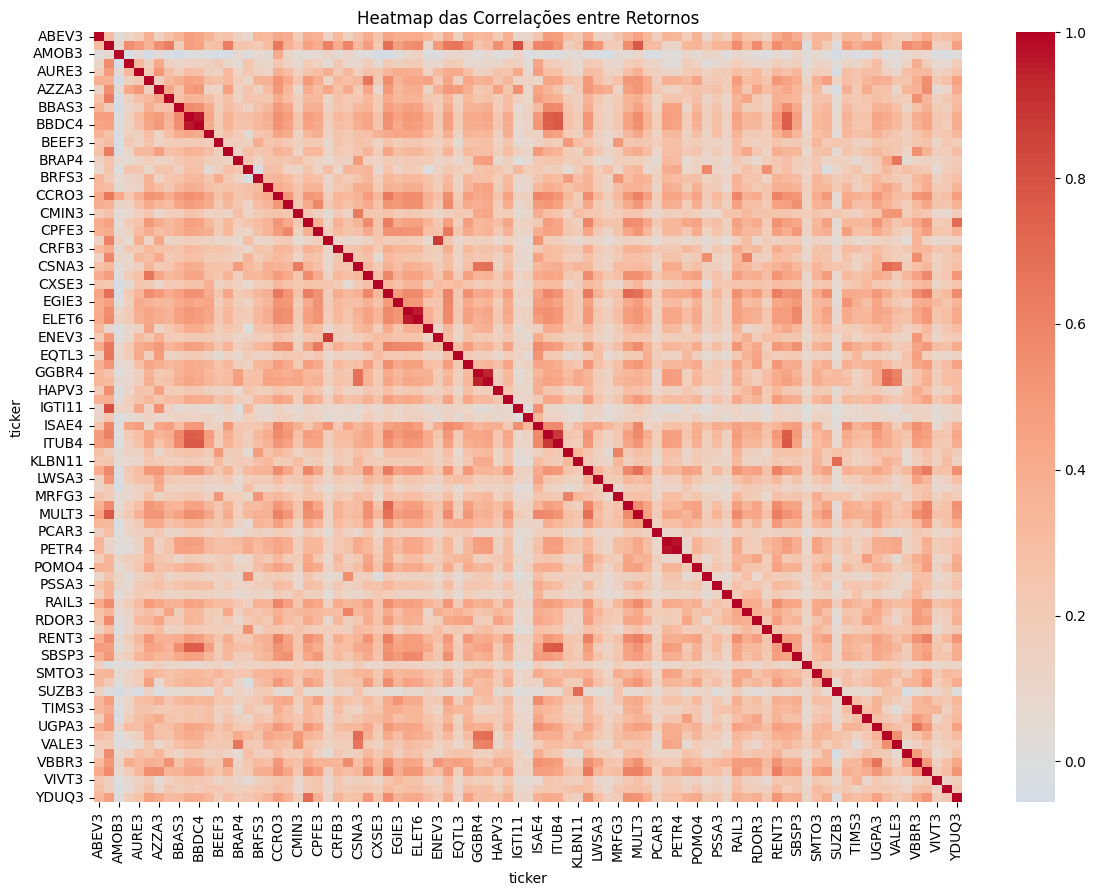

In [9]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, center=0)
plt.title("Heatmap das Correlações entre Retornos")
plt.show()

 Cálculo de portfólio long-only ótimo por média-variância e comparando com o índice Bovespa.

A otimização de portfólio long-only (sem posições vendidas), usando o modelo média-variância de Markowitz e comparando o desempenho com o índice Bovespa.

In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
# Lista dos ativos da nova carteira
# aqui eu modifiquei os tickers para poder formar a carteira 2, sao tickers que estao abaixo do Ibov
tickers = [
    "ITUB4.SA", "TRAD3.SA", "BPAC11.SA", "PGMN3.SA", "SMFT3.SA",
    "POSI3.SA", "TIMS3.SA", "VALE3.SA", "FESA4.SA", "PSSA3.SA",
    "CYRE3.SA", "MRVE3.SA", "TRIS3.SA", "DIRR3.SA", "VBBR3.SA",
    "RADL3.SA", "COGN3.SA", "TOTS3.SA", "BPAC5.SA", "ASAI3.SA"
]

# Baixar os dados
dados = yf.download(tickers, start="2022-03-29", end="2025-06-04")["Close"]
#dados = dados

# Retornos percentuais diários
retornos = dados.pct_change()

# Geração de pesos aleatórios normalizados com 6 casas decimais
pesos = np.random.dirichlet(np.ones(len(retornos.columns)), size=1).round(6)[0]
pesos = pesos / pesos.sum()  # Garante soma próxima de 1

# Criação do DataFrame de pesos
pesos_df = pd.DataFrame({
    'Ticker': retornos.columns,
    'sum_escolhido': pesos
})

print("\n📊 Pesos atribuídos à nova carteira:")
print(pesos_df)



[*********************100%***********************]  20 of 20 completed



📊 Pesos atribuídos à nova carteira:
       Ticker  sum_escolhido
0    ASAI3.SA       0.008887
1   BPAC11.SA       0.003702
2    BPAC5.SA       0.045612
3    COGN3.SA       0.011343
4    CYRE3.SA       0.045663
5    DIRR3.SA       0.033428
6    FESA4.SA       0.034667
7    ITUB4.SA       0.075939
8    MRVE3.SA       0.103678
9    PGMN3.SA       0.094282
10   POSI3.SA       0.066241
11   PSSA3.SA       0.083329
12   RADL3.SA       0.058937
13   SMFT3.SA       0.003692
14   TIMS3.SA       0.004696
15   TOTS3.SA       0.001785
16   TRAD3.SA       0.026158
17   TRIS3.SA       0.204513
18   VALE3.SA       0.062682
19   VBBR3.SA       0.030765


In [15]:
# Retorno acumulado da carteira
retorno_carteira = (retornos * pesos).sum(axis=1)
carteira_acumulada = (1 + retorno_carteira).cumprod().reset_index()
carteira_acumulada.columns = ['Date', 'carteira_escolhida']

# IBOV acumulado
ibov = yf.download("^BVSP", start="2022-03-29", end="2025-06-04")['Close'].pct_change().dropna()
ibov_acumulado = (1 + ibov).cumprod().reset_index()
ibov_acumulado.columns = ['Date', 'IBOV']

# Merge dos dois retornos acumulados
comparacao = pd.merge(ibov_acumulado, carteira_acumulada, how='inner', on='Date')

[*********************100%***********************]  1 of 1 completed


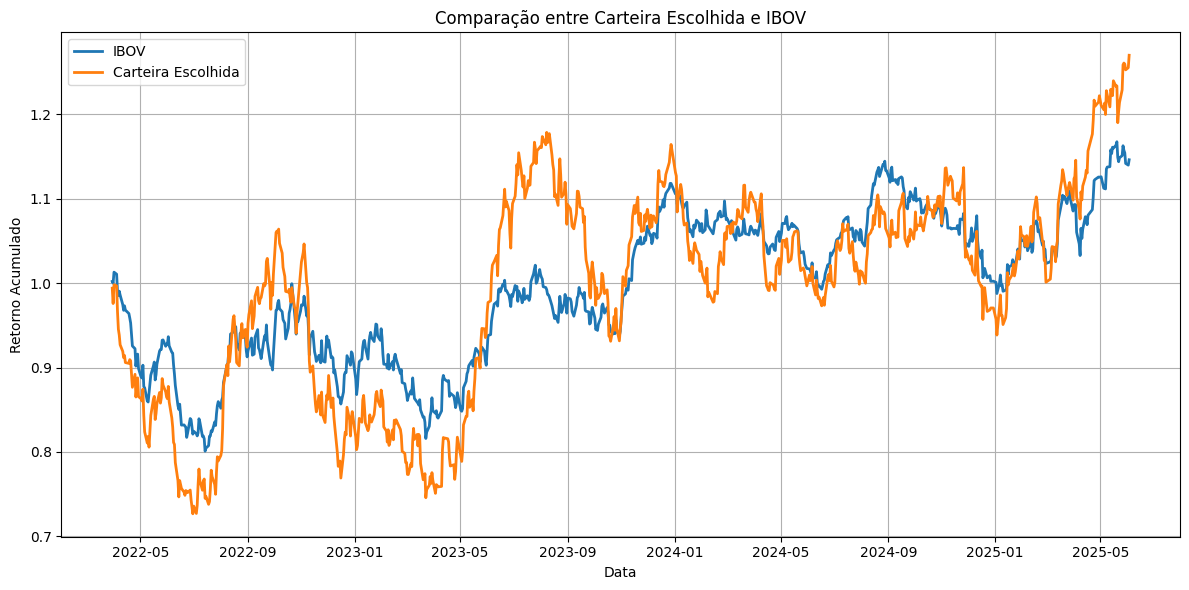

In [16]:
# Plotar gráfico
plt.figure(figsize=(12, 6))
plt.plot(comparacao['Date'], comparacao['IBOV'], label='IBOV', linewidth=2)
plt.plot(comparacao['Date'], comparacao['carteira_escolhida'], label='Carteira Escolhida', linewidth=2)
#plt.plot(comparacao['Date'], comparacao['carteira_escolhida'], label='Carteira Escolhida', linewidth=2)
plt.title('Comparação entre Carteira Escolhida e IBOV')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========== Carteira 1 ==========
tickers1 = [
    "ASAI3.SA", "BBAS3.SA", "BBDC4.SA", "BGIP3.SA", "BPAC5.SA", "COGN3.SA",
    "CSMG3.SA", "CYRE3.SA", "DIRR3.SA", "FESA4.SA", "GOAU4.SA", "ITUB4.SA",
    "JHSF3.SA", "MRVE3.SA", "PETR4.SA", "PSSA3.SA", "RADL3.SA", "TRAD3.SA",
    "TRIS3.SA", "VBBR3.SA"
]
pesos1 = [
    0.054640, 0.008674, 0.019949, 0.026344, 0.035157, 0.088794,
    0.012860, 0.041687, 0.051818, 0.002746, 0.054002, 0.010794,
    0.008308, 0.171689, 0.194607, 0.095399, 0.020975, 0.005934,
    0.066555, 0.033495
]
"""
# ========== Carteira 2.2 ==========
tickers2 = [
    'ASAI3.SA', 'BPAC11.SA', 'BPAC5.SA', 'COGN3.SA', 'CSMG3.SA',
    'CYRE3.SA', 'DIRR3.SA', 'FESA4.SA', 'ITUB4.SA', 'MRVE3.SA',
    'PGMN3.SA', 'POSI3.SA', 'PSSA3.SA', 'RADL3.SA', 'SMFT3.SA',
    'TIMS3.SA', 'TOTS3.SA', 'TRAD3.SA', 'TRIS3.SA', 'VBBR3.SA'
]
pesos2 = [
    0.048409, 0.076178, 0.065579, 0.019953, 0.168226,
    0.081352, 0.049104, 0.057476, 0.033053, 0.017295,
    0.026733, 0.086162, 0.000881, 0.007496, 0.002861,
    0.002526, 0.107513, 0.073893, 0.039053, 0.006255
]
"""

# ========== Carteira 2 ==========
tickers2 = [
    "ASAI3.SA", "BPAC11.SA", "BPAC5.SA", "COGN3.SA", "CYRE3.SA", "DIRR3.SA",
    "FESA4.SA", "ITUB4.SA", "MRVE3.SA", "PGMN3.SA", "POSI3.SA", "PSSA3.SA",
    "RADL3.SA", "SMFT3.SA", "TIMS3.SA", "TOTS3.SA", "TRAD3.SA", "TRIS3.SA",
    "VALE3.SA", "VBBR3.SA"
]

pesos2 = [
    0.044831, 0.028746, 0.013862, 0.062909, 0.043202, 0.006642,
    0.090507, 0.064709, 0.111969, 0.048414, 0.035570, 0.020274,
    0.101013, 0.075241, 0.001732, 0.001000, 0.017678, 0.062264,
    0.163337, 0.006101
]
#pesos2 = np.array(pesos2)
#pesos2 = pesos2 / pesos2.sum()  # Normaliza

# ========== Datas ==========
start_date = "2022-03-29"
end_date = "2025-06-04"

In [31]:
#set(tickers1) - set(tickers2)

In [32]:
# ========== Função para processar carteira ==========
def calcular_carteira(tickers, pesos, nome_coluna):
    dados = yf.download(tickers, start=start_date, end=end_date)["Close"]
    dados = dados.dropna(axis=1, how="all")
    retornos = dados.pct_change().dropna()
    pesos_alinhados = pd.Series(pesos, index=tickers)
    pesos_alinhados = pesos_alinhados.loc[dados.columns].values
    retorno_diario = (retornos * pesos_alinhados).sum(axis=1)
    retorno_acumulado = (1 + retorno_diario).cumprod().reset_index()
    retorno_acumulado.columns = ['Date', nome_coluna]
    return retorno_acumulado

# ========== Calcula carteiras ==========
carteira1 = calcular_carteira(tickers1, pesos1, 'Carteira 1')
carteira2 = calcular_carteira(tickers2, pesos2, 'Carteira 2')

# ========== IBOV ==========
ibov = yf.download("^BVSP", start=start_date, end=end_date)["Close"].pct_change().dropna()
ibov_acumulado = (1 + ibov).cumprod().reset_index()
ibov_acumulado.columns = ['Date', 'IBOV']

# ========== Merge geral ==========
comparativo = ibov_acumulado.merge(carteira1, on='Date', how='inner').merge(carteira2, on='Date', how='inner')


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  1 of 1 completed


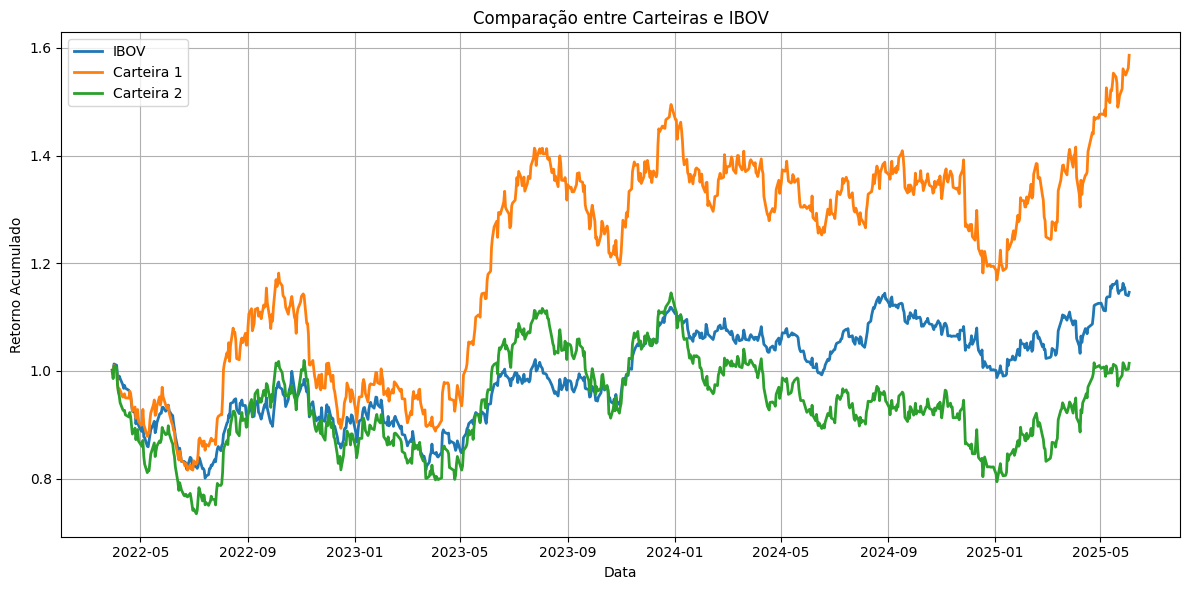

In [33]:
# ========== Plot ==========
plt.figure(figsize=(12, 6))
plt.plot(comparativo['Date'], comparativo['IBOV'], label='IBOV', linewidth=2)
plt.plot(comparativo['Date'], comparativo['Carteira 1'], label='Carteira 1', linewidth=2)
plt.plot(comparativo['Date'], comparativo['Carteira 2'], label='Carteira 2', linewidth=2)
plt.title('Comparação entre Carteiras e IBOV')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

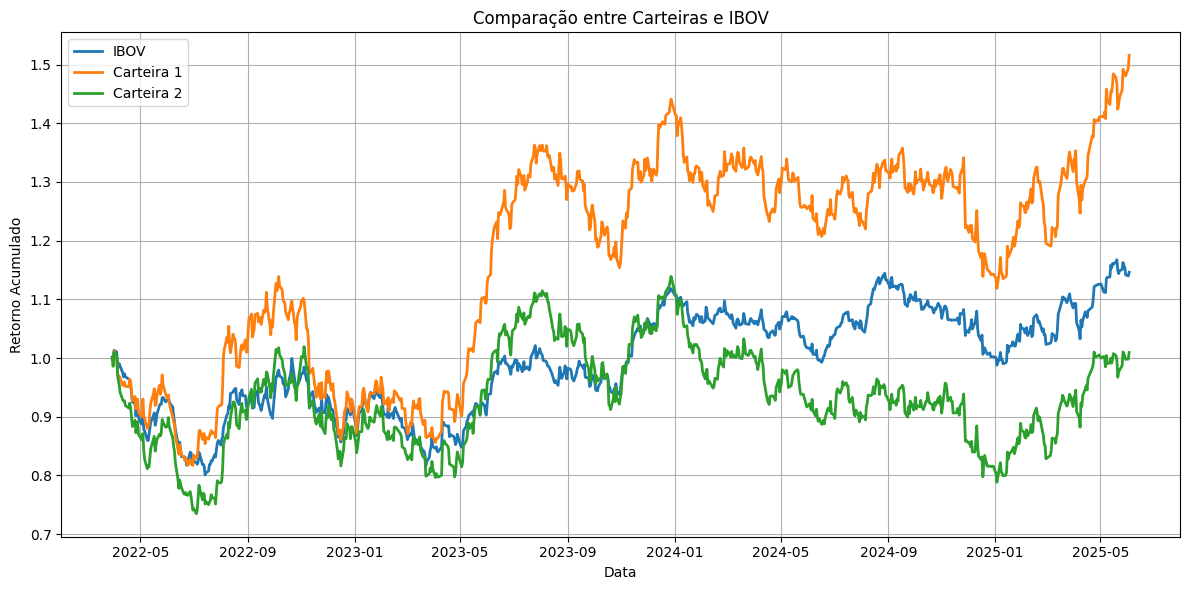

In [354]:
# ========== Plot ==========
plt.figure(figsize=(12, 6))
plt.plot(comparativo['Date'], comparativo['IBOV'], label='IBOV', linewidth=2)
plt.plot(comparativo['Date'], comparativo['Carteira 1'], label='Carteira 1', linewidth=2)
plt.plot(comparativo['Date'], comparativo['Carteira 2'], label='Carteira 2', linewidth=2)
plt.title('Comparação entre Carteiras e IBOV')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Analisando os resultados

In [ ]:
# Lista de tickers da Carteira 1 sem o sufixo ".SA"
tickers_carteira1 = [
    "ASAI3", "BBAS3", "BBDC4", "BGIP3", "BPAC5", "COGN3",
    "CSMG3", "CYRE3", "DIRR3", "FESA4", "GOAU4", "ITUB4",
    "JHSF3", "MRVE3", "PETR4", "PSSA3", "RADL3", "TRAD3",
    "TRIS3", "VBBR3"
]

# Selecionar apenas os tickers da Carteira 1 já pivotados ou apenas tickers1 já declarado em blocos anteriores
#df_carteira1 = df_pivot.loc[:, df_pivot.columns.isin(tickers_carteira1)]
df_carteira1 = pivot_returns.loc[:, pivot_returns.columns.isin(tickers_carteira1)]

# Matriz de covariância
cov_matrix = df_carteira1.cov()

# Heatmap da correlacao
corr_matrix = df_carteira1.corr()

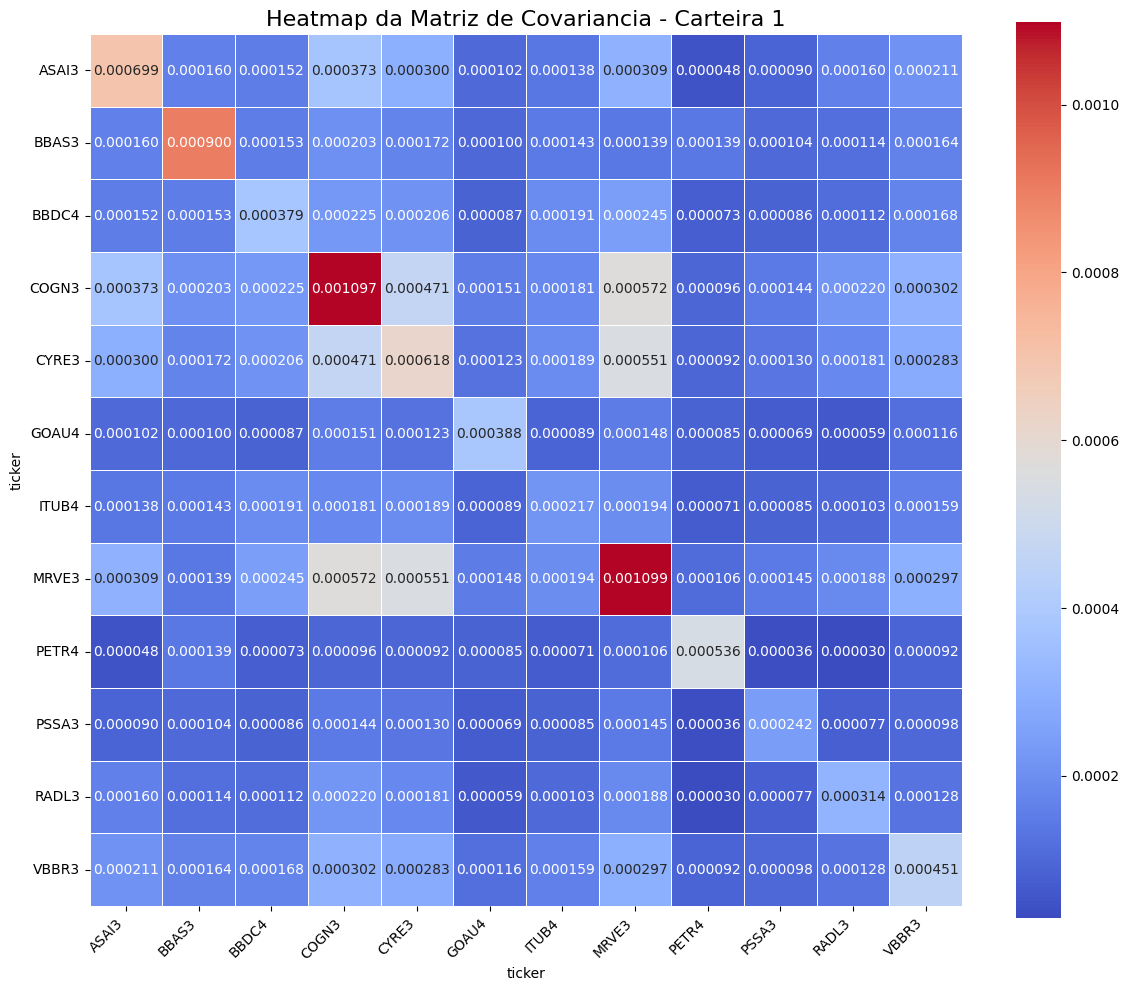

In [59]:
# Plot da Matriz de covaraincia
plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix, annot=True, fmt=".6f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Heatmap da Matriz de Covariancia - Carteira 1", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

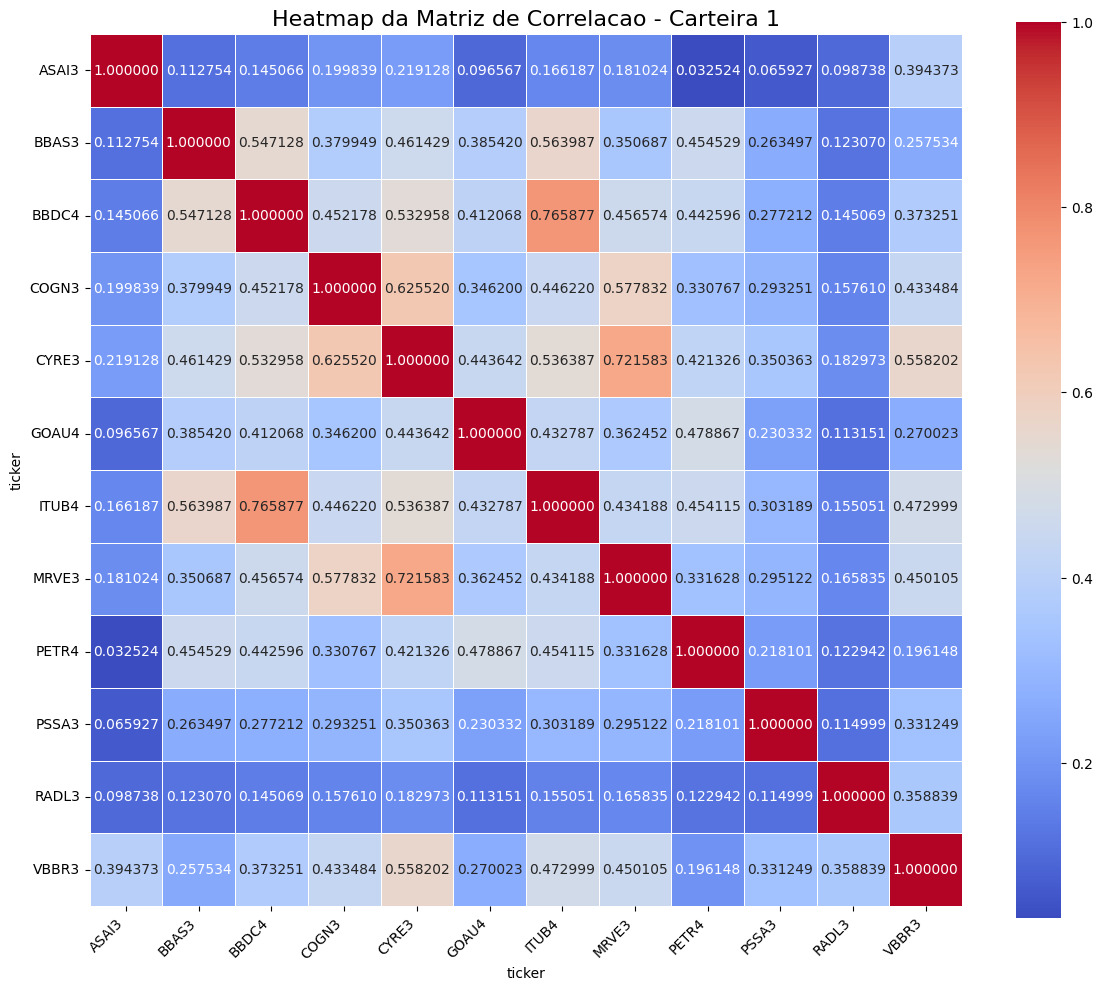

In [58]:
# Plot do heatmap da correlacao
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".6f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Heatmap da Matriz de Correlacao - Carteira 1", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

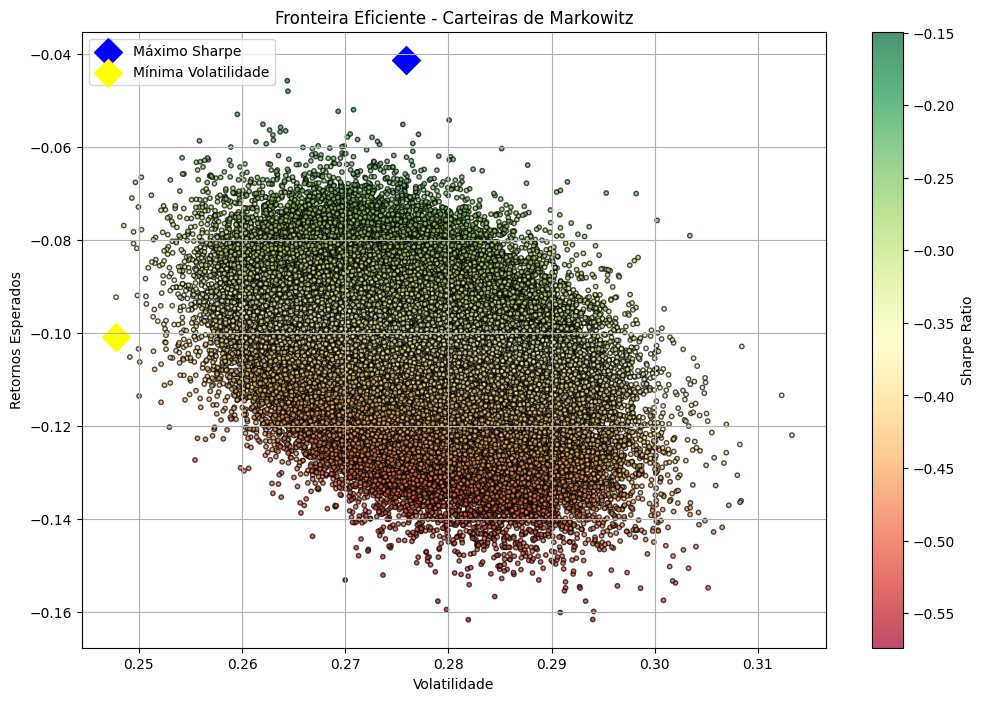

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Criar DataFrame com os dados
markowitzDF = pd.DataFrame({
    'Retornos': port_returns,
    'Volatilidade': port_volatility,
    'Sharpe Ratio': sharpe_ratio
})

# Encontrar as carteiras especiais
min_volatility = markowitzDF['Volatilidade'].min()
max_sharpe = markowitzDF['Sharpe Ratio'].max()

sharpe_portfolio = markowitzDF.loc[markowitzDF['Sharpe Ratio'] == max_sharpe]
min_variance_port = markowitzDF.loc[markowitzDF['Volatilidade'] == min_volatility]

# Se tiver uma carteira escolhida, defina a volatilidade e retorno dela:
# Exemplo:
# volatility_carteira_escolhida = 0.20
# returns_carteira_escolhida = 0.25

# Criar o gráfico
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    markowitzDF['Volatilidade'],
    markowitzDF['Retornos'],
    c=markowitzDF['Sharpe Ratio'],
    cmap='RdYlGn',
    s=10,
    alpha=0.7,
    edgecolors='k'
)

plt.colorbar(scatter, label='Sharpe Ratio')

# Destacar os portfólios especiais
plt.scatter(sharpe_portfolio['Volatilidade'], sharpe_portfolio['Retornos'],
            c='blue', marker='D', s=200, label='Máximo Sharpe')

plt.scatter(min_variance_port['Volatilidade'], min_variance_port['Retornos'],
            c='yellow', marker='D', s=200, label='Mínima Volatilidade')

# Descomente esta parte se tiver uma carteira específica:
# plt.scatter(volatility_carteira_escolhida, returns_carteira_escolhida,
#             c='red', marker='D', s=200, label='Carteira Escolhida')

plt.title('Fronteira Eficiente - Carteiras de Markowitz')
plt.xlabel('Volatilidade')
plt.ylabel('Retornos Esperados')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
# Fazendo o Inner Join dos tickers ibov que correspondem ao bovespa - apenas pega os tickers em comum ou seja o que está contido nas duas tabelas
# op1 e op2 fazem a mesma coisa mas usando códigos diferentes.
# op1: 
# tickers_ibov = df_ibov["ticker"].unique()
# df_bovespa_2 = df_bovespa.copy()
# df_bovespa_2 = df_bovespa_2.loc[df_bovespa_2["ticker"].isin(tickers_ibov)]

# df_bovespa_2

#op2:

df_bovespa_2 = pd.merge(
    df_bovespa, df_ibov,
    left_on=["ticker"],
    right_on=["ticker"],
    how="inner"
)
df_bovespa_2 

,date,ticker,close,log_return,volatility_20d
0,2020-01-02,ABEV3,19.20,NaN,NaN
1,2020-01-03,ABEV3,18.93,-0.014162,NaN
2,2020-01-06,ABEV3,19.02,0.004743,NaN
3,2020-01-07,ABEV3,19.06,0.002101,NaN
4,2020-01-08,ABEV3,18.97,-0.004733,NaN
...,...,...,...,...,...
98589,2024-12-20,YDUQ3,8.69,0.047123,0.044136
98590,2024-12-23,YDUQ3,8.41,-0.032751,0.043484
98591,2024-12-26,YDUQ3,8.24,-0.020421,0.043257
98592,2024-12-27,YDUQ3,8.32,0.009662,0.042457


In [ ]:
print(df_ibov.columns)

Index(['ticker'], dtype='object')


In [ ]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.
